# ElasticNet

## Imports / Settings

In [1]:
%pip install dotenv

Note: you may need to restart the kernel to use updated packages.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
import os
import wandb

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from utils.evaluationUtility import evaluate_classifier, analyze_all_results

In [4]:
IS_PAPERSPACE = os.getcwd().startswith('/notebooks')
dir_env = os.path.join(os.getcwd(), '.env') if IS_PAPERSPACE else os.path.join(os.getcwd(), '..', '.env')
_ = load_dotenv(dotenv_path=dir_env)

In [5]:
wandb.login(key=os.getenv('WANDB_KEY'))
wandb._disable_jupyter = True

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Data

In [6]:
df_traindata = pd.read_csv("data/train.csv") if IS_PAPERSPACE else pd.read_csv("../data/train.csv")
train_texts, validation_texts, train_labels, validation_labels = train_test_split(
    df_traindata['text'].tolist(), 
    df_traindata['sentiment'].tolist(), 
    test_size=0.2, 
    random_state=42
)

df_testdata = pd.read_csv("data/test.csv") if IS_PAPERSPACE else pd.read_csv("../data/test.csv")
test_texts = df_testdata['text'].tolist()
test_labels = df_testdata['sentiment'].tolist()

## Vectorization

In [7]:
countVectorizer = CountVectorizer()
tfidfVectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

## Training

In [9]:
classifier = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=20, n_jobs=-1)

In [11]:
evaluate_classifier(
    classifier=classifier,
    classifier_name="RandomForest",
    vectorizer=countVectorizer,
    vectorizer_name="CountVectorizer",
    train_texts=train_texts,
    train_labels=train_labels,
    validation_texts=validation_texts,
    validation_labels=validation_labels,
    test_texts=test_texts,
    test_labels=test_labels,
    model_name="randomForest")


Classifier: RandomForest | Vectorizer: CountVectorizer
Validation Accuracy: 0.5827
Test Accuracy: 0.5815
Training Duration: 6.43 seconds


wandb: Currently logged in as: dario-wigger (nlp-lantsch-schmassmann-wigger). Use `wandb login --relogin` to force relogin


f1,▁
precision,▁
recall,▁
f1,0.43085
precision,0.74521
recall,0.58146


In [12]:
evaluate_classifier(
    classifier=classifier,
    classifier_name="RandomForest",
    vectorizer=tfidfVectorizer,
    vectorizer_name="TfidfVectorizer",
    train_texts=train_texts,
    train_labels=train_labels,
    validation_texts=validation_texts,
    validation_labels=validation_labels,
    test_texts=test_texts,
    test_labels=test_labels,
    model_name="randomForest")


Classifier: RandomForest | Vectorizer: TfidfVectorizer
Validation Accuracy: 0.6707
Test Accuracy: 0.6684
Training Duration: 12.96 seconds


f1,▁
precision,▁
recall,▁
f1,0.61514
precision,0.72502
recall,0.66839


## Hyperparameter Tuning

In [ ]:
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [20, 50],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__max_features': ['sqrt'],
    'classifier__class_weight': ['balanced']
}

grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_macro', n_jobs=-1, verbose=2)
grid.fit(train_texts, train_labels)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('classifier',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__class_weight': ['balanced'],
                         'classifier__max_depth': [20, 50],
                         'classifier__max_features': ['sqrt'],
                         'classifier__min_samples_leaf': [1, 2],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='f1_macro', verbose=2)

[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200; total time=  45.7s
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=100; total time=  30.0s
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=200; total time=  29.9s
[CV] END classifier__class_weight=balanced, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200; total time= 5.6min
[CV] END classifier__class_weight=balanced, classifier__max_depth=50, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classif

In [24]:
print("Best Parameters:", grid.best_params_)

Best Parameters: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 50, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}


In [8]:
evaluate_classifier(
    classifier=RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, class_weight='balanced', max_depth=50, max_features='sqrt', min_samples_leaf=1, min_samples_split=2),
    classifier_name="RandomForest-Tuned",
    vectorizer=tfidfVectorizer,
    vectorizer_name="TfidfVectorizer",
    train_texts=train_texts,
    train_labels=train_labels,
    validation_texts=validation_texts,
    validation_labels=validation_labels,
    test_texts=test_texts,
    test_labels=test_labels,
    model_name="randomForest"
)


Classifier: RandomForest-Tuned | Vectorizer: TfidfVectorizer
Validation Accuracy: 0.7494
Test Accuracy: 0.7468
Training Duration: 51.13 seconds


wandb: Currently logged in as: dario-wigger (nlp-lantsch-schmassmann-wigger). Use `wandb login --relogin` to force relogin


f1,▁
precision,▁
recall,▁
f1,0.74704
precision,0.74737
recall,0.74677


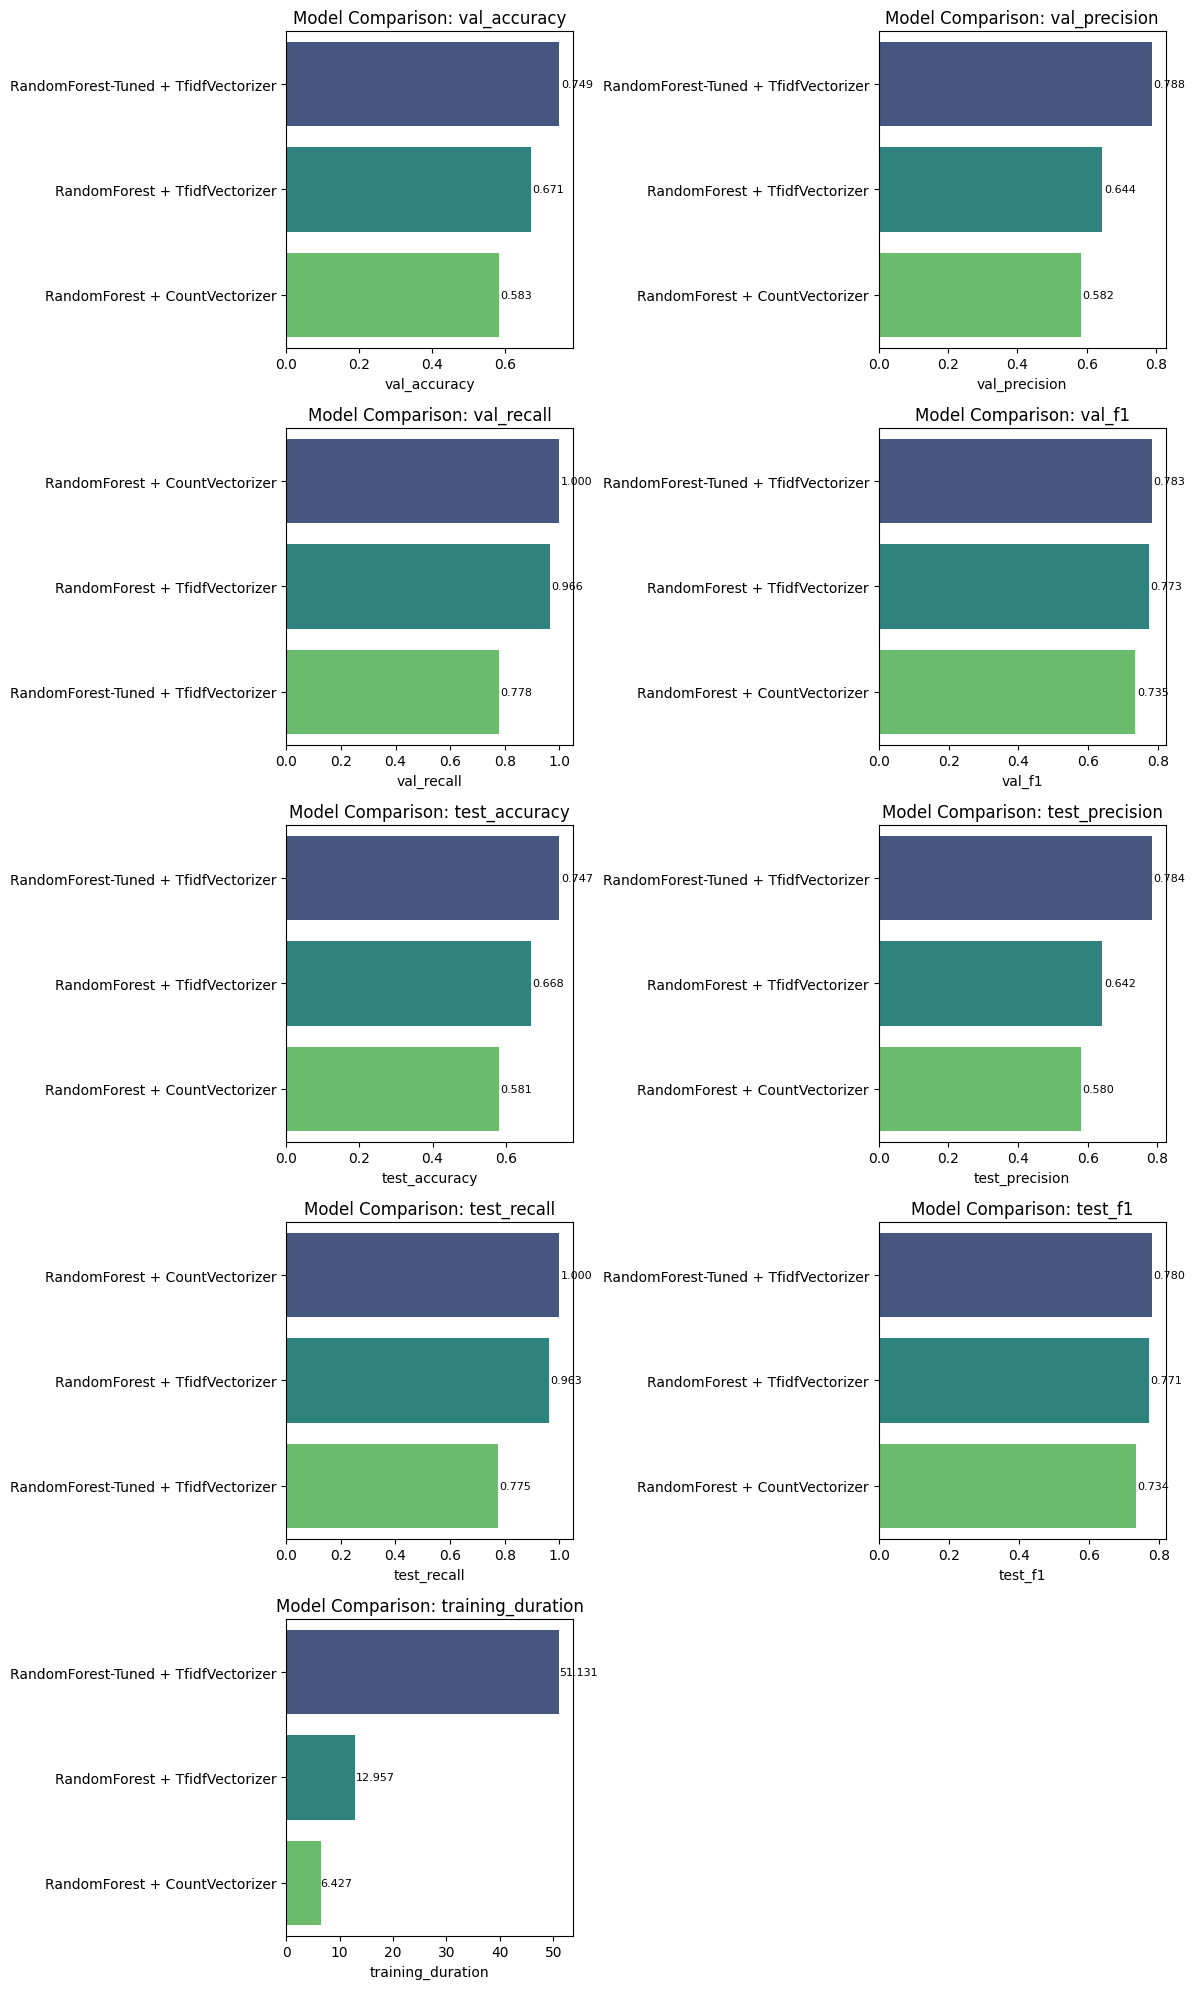

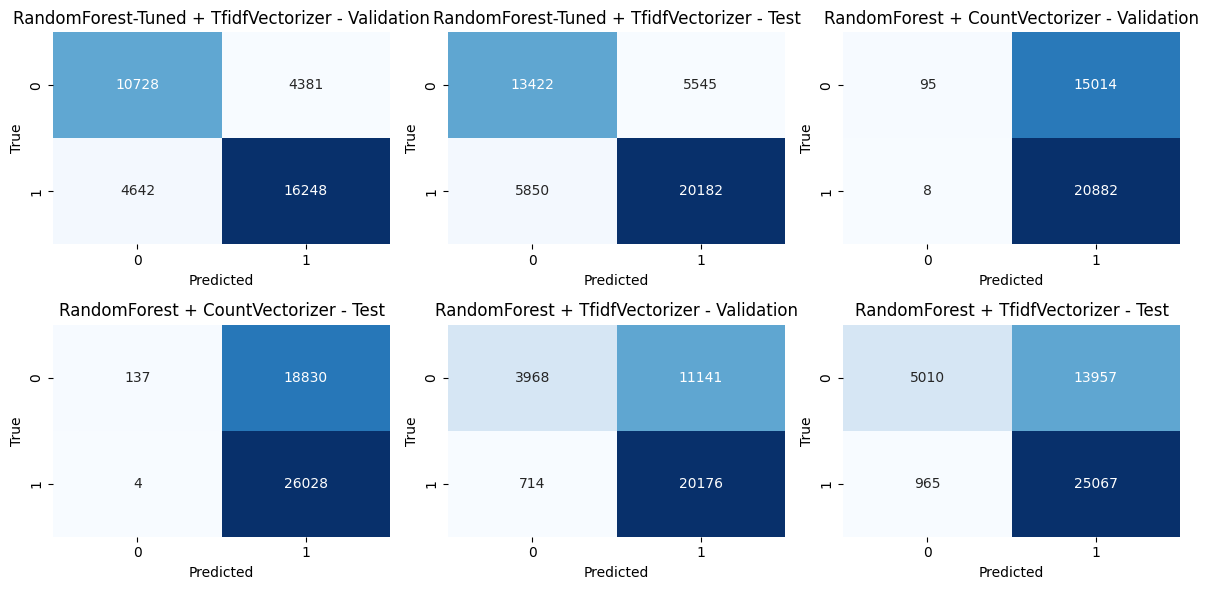

,classifier,vectorizer,val_accuracy,val_precision,val_recall,val_f1,test_accuracy,test_precision,test_recall,test_f1,training_duration,Classifier,Vectorizer,Validation Confusion,Test Confusion,Model
0,RandomForest-Tuned,TfidfVectorizer,0.749354,0.787629,0.777788,0.782678,0.746772,0.784468,0.775277,0.779845,51.130997,RandomForest-Tuned,TfidfVectorizer,"[[10728, 4381], [4642, 16248]]","[[13422, 5545], [5850, 20182]]",RandomForest-Tuned + TfidfVectorizer
1,RandomForest,CountVectorizer,0.582711,0.581736,0.999617,0.735463,0.581457,0.580231,0.999846,0.734321,6.427010,RandomForest,CountVectorizer,"[[95, 15014], [8, 20882]]","[[137, 18830], [4, 26028]]",RandomForest + CountVectorizer
2,RandomForest,TfidfVectorizer,0.670685,0.644251,0.965821,0.772923,0.668393,0.642348,0.962930,0.770628,12.957320,RandomForest,TfidfVectorizer,"[[3968, 11141], [714, 20176]]","[[5010, 13957], [965, 25067]]",RandomForest + TfidfVectorizer


In [6]:
analyze_all_results(results_dir="executions/randomForest")